# Introduction to Deep Learning Final Project: Wildlife Animals Classification 
Zhen Lian

## Overview
The goal of this project is to develop a classifier based on convolutional neural network that classify wildlife animals. The data set used in this project contains photos from 6 types of wild animals and is available from Kaggle: https://www.kaggle.com/datasets/anshulmehtakaggl/wildlife-animals-images

## Exploratory data analysis
First, let us check how many images are in the dataset and the dimensions of the images.

In [2]:
import glob
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from PIL import Image

In [2]:
sub_dirs = glob.glob('.\\images\\**\\')
sub_dirs

['.\\images\\cheetah\\',
 '.\\images\\fox\\',
 '.\\images\\hyena\\',
 '.\\images\\lion\\',
 '.\\images\\tiger\\',
 '.\\images\\wolf\\']

Images belong to each class is stored in a sub-folder, there are 6 classes in total.

In [3]:
classes = [c_name.lstrip('.\\images\\').rstrip('\\') for c_name in sub_dirs]
classes

['cheetah', 'fox', 'hyena', 'lion', 'tiger', 'wolf']

Loop through subfolders and check the size and color channels of the images.

In [4]:
image_info = list()
file_names, labels = list(), list()
widths, heights, modes, sizes = list(), list(), list(), list()
for i in range(len(classes)):
    image_list = glob.glob(sub_dirs[i] + '*.png')
    for file_name in image_list:
        try:
            img = Image.open(file_name)
            image_info.append([file_name, classes[i], i, img.width, img.height, img.mode])
        except Exception as e:
            print('error loading {}'.format(file_name))
            print(e)
            continue

error loading .\images\cheetah\00000244_224resized.png
cannot identify image file '.\\images\\cheetah\\00000244_224resized.png'
error loading .\images\hyena\00000224_224resized.png
cannot identify image file '.\\images\\hyena\\00000224_224resized.png'


Store the information into a dataframe.

In [5]:
arr = np.array(image_info)
df = pd.DataFrame(arr, columns=['image_name', 'class', 'class_id', 'width', 'height', 'mode'])
df

,image_name,class,class_id,width,height,mode
0,.\images\cheetah\00000000_224resized.png,cheetah,0,224,224,RGB
1,.\images\cheetah\00000001_224resized.png,cheetah,0,224,224,RGB
2,.\images\cheetah\00000002_224resized.png,cheetah,0,224,224,RGB
3,.\images\cheetah\00000003_224resized.png,cheetah,0,224,224,RGB
4,.\images\cheetah\00000004_224resized.png,cheetah,0,224,224,RGB
...,...,...,...,...,...,...
1718,.\images\wolf\00000540_224resized.png,wolf,5,224,224,RGB
1719,.\images\wolf\00000547_224resized.png,wolf,5,224,224,RGB
1720,.\images\wolf\00000548_224resized.png,wolf,5,224,224,RGB
1721,.\images\wolf\00000549_224resized.png,wolf,5,224,224,RGB


Check the channels of the images and use RGB images only.

In [6]:
df[['width', 'height', 'mode']].value_counts()

width  height  mode
224    224     RGB     1693
               RGBA      25
               P          4
               L          1
dtype: int64

In [7]:
df = df[df['mode']=='RGB']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1693 entries, 0 to 1722
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  1693 non-null   object
 1   class       1693 non-null   object
 2   class_id    1693 non-null   object
 3   width       1693 non-null   object
 4   height      1693 non-null   object
 5   mode        1693 non-null   object
dtypes: object(6)
memory usage: 92.6+ KB


In [8]:
df['class'].value_counts()

cheetah    341
hyena      296
lion       286
tiger      265
wolf       260
fox        245
Name: class, dtype: int64

Let us take a random sample from the images and see how they look like.

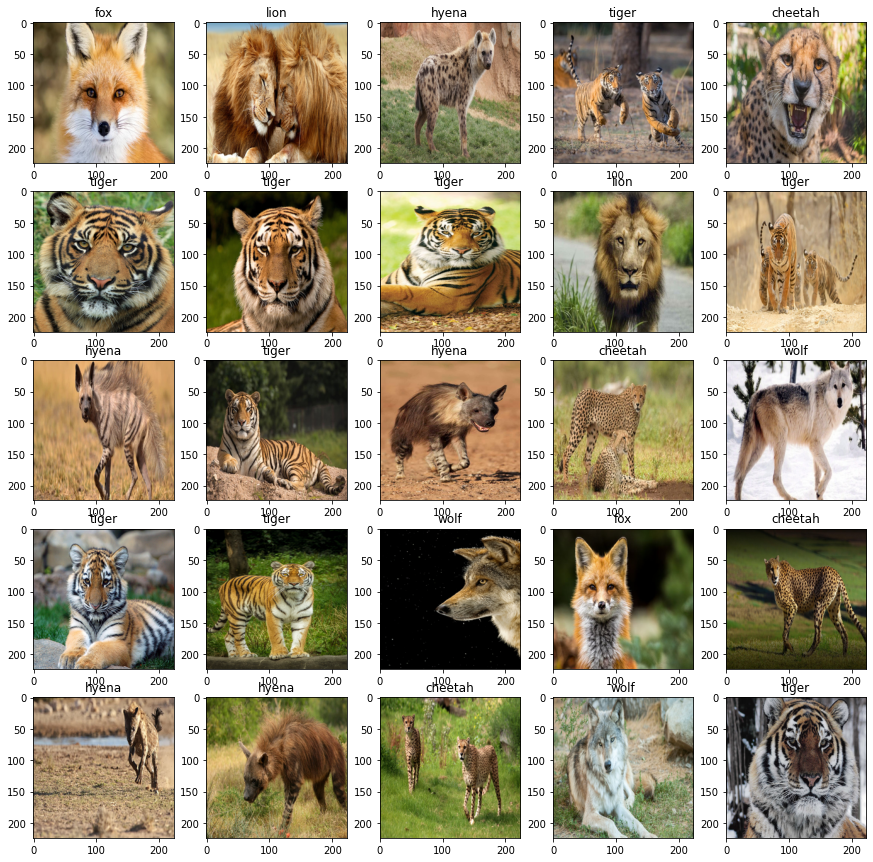

In [9]:
sample = df.sample(25)
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    img, class_name = Image.open(sample['image_name'].iloc[i]), sample['class'].iloc[i]
    plt.imshow(img)
    plt.title(class_name)

Since this dataset is quite small, it can be directly loaded into memory as numpy array.

In [10]:
X = np.zeros([len(df), 224, 224, 3])
for i in range(len(df)):
    file_name = df['image_name'].iloc[i]
    img = Image.open(file_name)
    X[i, :, :, :] = np.array(img)


In [11]:
y_id = df['class_id'].to_numpy().astype(np.int32)
y = np.zeros([len(y_id), 6]).astype(np.int32)
for row in range(y.shape[0]):
    y[row, y_id[row]] = 1

In [12]:
X.shape, y.shape

((1693, 224, 224, 3), (1693, 6))

In [13]:
np.save('X', X)
np.save('y', y)

In [3]:
X = np.load('X.npy')
y = np.load('y.npy')

## Model training and evaluation

In [24]:
import keras
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Use 5-fold cross-validation to evaluate result.

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)

Start with a simple model with 2 convolutional layers and one dense layer.

In [29]:
def model_1():
    model = tf.keras.Sequential([
    Rescaling(1./255),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),  
    Flatten(),

    Dense(32, activation='relu'),
    Dense(6, activation='softmax')
    ])
    return model

In [9]:
def train_model(model_func, model_name, lr=0.0001, epochs=30):
    histories = list()
    model = None
    for train_index, test_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
    
        model = model_func()

        model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()])

        callback = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data = (X_val, y_val),
        batch_size=10,
        validation_batch_size=10)
            
        histories.append(callback.history)
    model.save(model_name)
    del model
    return histories
        
    

In [40]:
histories = train_model(model_1,'model_1', lr=0.0001, epochs=30)

Epoch 1/30
43/43 [==============================] - 2s 40ms/step - loss: 2.3019 - categorical_accuracy: 0.3685 - val_loss: 1.7404 - val_categorical_accuracy: 0.2448
Epoch 2/30
43/43 [==============================] - 1s 32ms/step - loss: 0.8494 - categorical_accuracy: 0.7112 - val_loss: 1.7996 - val_categorical_accuracy: 0.2242
Epoch 3/30
43/43 [==============================] - 1s 32ms/step - loss: 0.3540 - categorical_accuracy: 0.8900 - val_loss: 1.9289 - val_categorical_accuracy: 0.2035
Epoch 4/30
43/43 [==============================] - 1s 33ms/step - loss: 0.1426 - categorical_accuracy: 0.9719 - val_loss: 2.1446 - val_categorical_accuracy: 0.2566
Epoch 5/30
43/43 [==============================] - 1s 32ms/step - loss: 0.0597 - categorical_accuracy: 0.9919 - val_loss: 2.3114 - val_categorical_accuracy: 0.2714
Epoch 6/30
43/43 [==============================] - 1s 32ms/step - loss: 0.0348 - categorical_accuracy: 0.9978 - val_loss: 2.1753 - val_categorical_accuracy: 0.3038
Epoch 7/30

43/43 [==============================] - 1s 32ms/step - loss: 0.0163 - categorical_accuracy: 0.9978 - val_loss: 2.8205 - val_categorical_accuracy: 0.3373
Epoch 10/30
43/43 [==============================] - 1s 32ms/step - loss: 0.0123 - categorical_accuracy: 0.9978 - val_loss: 2.4972 - val_categorical_accuracy: 0.3728
Epoch 11/30
43/43 [==============================] - 1s 32ms/step - loss: 0.0096 - categorical_accuracy: 0.9993 - val_loss: 2.2571 - val_categorical_accuracy: 0.4172
Epoch 12/30
43/43 [==============================] - 1s 32ms/step - loss: 0.0080 - categorical_accuracy: 0.9993 - val_loss: 1.9980 - val_categorical_accuracy: 0.4615
Epoch 13/30
43/43 [==============================] - 1s 32ms/step - loss: 0.0070 - categorical_accuracy: 1.0000 - val_loss: 1.8411 - val_categorical_accuracy: 0.5059
Epoch 14/30
43/43 [==============================] - 1s 32ms/step - loss: 0.0059 - categorical_accuracy: 1.0000 - val_loss: 1.7464 - val_categorical_accuracy: 0.5355
Epoch 15/30
43/4

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


In [8]:
def evaluate(histories):
    n_epoch = len(histories[0]['loss'])
    train_loss = np.zeros( n_epoch).astype(np.float64)
    train_acc = np.zeros( n_epoch).astype(np.float64)
    val_loss = np.zeros( n_epoch).astype(np.float64)
    val_acc = np.zeros( n_epoch).astype(np.float64)
    for hist in histories:
        train_loss += np.array(hist['loss'])/len(histories)
        train_acc += np.array(hist['categorical_accuracy'])/len(histories)
        val_loss +=np.array(hist['val_loss'])/len(histories)
        val_acc += np.array(hist['val_categorical_accuracy'])/len(histories)
        
    plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('loss')
    plt.legend(['train', 'validation'])
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('accuracy')
    plt.legend(['train', 'validation'])
    
    best_epoch = np.argmin(val_loss)
    print('best_epoch: {} val_accuracy: {}'.format(best_epoch, val_acc[best_epoch]))
    
    return best_epoch, val_acc[best_epoch]

best_epoch: 14 val_accuracy: 0.5635230541229248


(14, 0.5635230541229248)

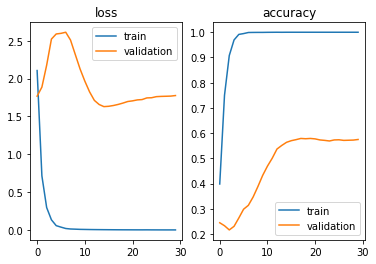

In [56]:
evaluate(histories)

In [57]:
def model_2():
    model = tf.keras.Sequential([
    Rescaling(1./255),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
        
        
    Flatten(),

    Dense(32, activation='relu'),
    Dense(6, activation='softmax')
    ])
    return model

Epoch 1/30
43/43 [==============================] - 3s 49ms/step - loss: 1.6882 - categorical_accuracy: 0.3988 - val_loss: 1.8781 - val_categorical_accuracy: 0.2301
Epoch 2/30
43/43 [==============================] - 2s 38ms/step - loss: 0.8392 - categorical_accuracy: 0.7149 - val_loss: 2.1074 - val_categorical_accuracy: 0.2242
Epoch 3/30
43/43 [==============================] - 2s 38ms/step - loss: 0.5399 - categorical_accuracy: 0.8434 - val_loss: 2.1803 - val_categorical_accuracy: 0.2507
Epoch 4/30
43/43 [==============================] - 2s 38ms/step - loss: 0.3392 - categorical_accuracy: 0.9276 - val_loss: 2.2774 - val_categorical_accuracy: 0.2035
Epoch 5/30
43/43 [==============================] - 2s 38ms/step - loss: 0.2234 - categorical_accuracy: 0.9712 - val_loss: 2.4538 - val_categorical_accuracy: 0.1829
Epoch 6/30
43/43 [==============================] - 2s 38ms/step - loss: 0.1571 - categorical_accuracy: 0.9845 - val_loss: 2.3548 - val_categorical_accuracy: 0.2684
Epoch 7/30

43/43 [==============================] - 2s 38ms/step - loss: 0.0459 - categorical_accuracy: 1.0000 - val_loss: 1.9155 - val_categorical_accuracy: 0.3905
Epoch 10/30
43/43 [==============================] - 2s 38ms/step - loss: 0.0369 - categorical_accuracy: 0.9993 - val_loss: 1.8038 - val_categorical_accuracy: 0.4290
Epoch 11/30
43/43 [==============================] - 2s 38ms/step - loss: 0.0337 - categorical_accuracy: 1.0000 - val_loss: 1.7090 - val_categorical_accuracy: 0.4497
Epoch 12/30
43/43 [==============================] - 2s 37ms/step - loss: 0.0249 - categorical_accuracy: 1.0000 - val_loss: 1.6224 - val_categorical_accuracy: 0.4675
Epoch 13/30
43/43 [==============================] - 2s 38ms/step - loss: 0.0195 - categorical_accuracy: 1.0000 - val_loss: 1.5376 - val_categorical_accuracy: 0.5178
Epoch 14/30
43/43 [==============================] - 2s 38ms/step - loss: 0.0183 - categorical_accuracy: 1.0000 - val_loss: 1.4791 - val_categorical_accuracy: 0.5503
Epoch 15/30
43/4

INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


best_epoch: 17 val_accuracy: 0.611947774887085


(17, 0.611947774887085)

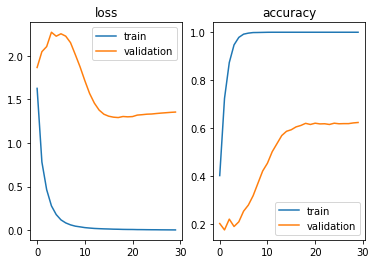

In [58]:
histories = train_model(model_2,'model_2', lr=0.0001, epochs=30)
evaluate(histories)

In [6]:
def model_3():
    model = tf.keras.Sequential([
    Rescaling(1./255),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
        
        
    Flatten(),

    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
    ])
    return model

Epoch 1/30
136/136 [==============================] - 7s 20ms/step - loss: 1.5586 - categorical_accuracy: 0.4719 - val_loss: 2.4701 - val_categorical_accuracy: 0.2242
Epoch 2/30
136/136 [==============================] - 2s 16ms/step - loss: 0.5218 - categorical_accuracy: 0.8294 - val_loss: 2.7785 - val_categorical_accuracy: 0.2271
Epoch 3/30
136/136 [==============================] - 2s 17ms/step - loss: 0.1925 - categorical_accuracy: 0.9572 - val_loss: 2.2208 - val_categorical_accuracy: 0.3481
Epoch 4/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0764 - categorical_accuracy: 0.9934 - val_loss: 1.2006 - val_categorical_accuracy: 0.5693
Epoch 5/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0405 - categorical_accuracy: 0.9985 - val_loss: 1.1714 - val_categorical_accuracy: 0.6106
Epoch 6/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0265 - categorical_accuracy: 0.9978 - val_loss: 1.1104 - val_categorical_accuracy: 0.640

Epoch 20/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0044 - categorical_accuracy: 0.9993 - val_loss: 1.2969 - val_categorical_accuracy: 0.6313
Epoch 21/30
136/136 [==============================] - 2s 16ms/step - loss: 0.2514 - categorical_accuracy: 0.9129 - val_loss: 2.5548 - val_categorical_accuracy: 0.4956
Epoch 22/30
136/136 [==============================] - 2s 16ms/step - loss: 0.2133 - categorical_accuracy: 0.9372 - val_loss: 1.7468 - val_categorical_accuracy: 0.5782
Epoch 23/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0268 - categorical_accuracy: 0.9926 - val_loss: 1.6336 - val_categorical_accuracy: 0.6224
Epoch 24/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0072 - categorical_accuracy: 0.9985 - val_loss: 1.6030 - val_categorical_accuracy: 0.6313
Epoch 25/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0034 - categorical_accuracy: 1.0000 - val_loss: 1.5664 - val_categorical_accuracy:

Epoch 9/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0115 - categorical_accuracy: 0.9993 - val_loss: 1.2872 - val_categorical_accuracy: 0.6095
Epoch 10/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0082 - categorical_accuracy: 1.0000 - val_loss: 1.3053 - val_categorical_accuracy: 0.5947
Epoch 11/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0078 - categorical_accuracy: 1.0000 - val_loss: 1.3043 - val_categorical_accuracy: 0.6124
Epoch 12/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0064 - categorical_accuracy: 1.0000 - val_loss: 1.3207 - val_categorical_accuracy: 0.6006
Epoch 13/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0052 - categorical_accuracy: 1.0000 - val_loss: 1.3052 - val_categorical_accuracy: 0.6213
Epoch 14/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0049 - categorical_accuracy: 1.0000 - val_loss: 1.3331 - val_categorical_accuracy: 

Epoch 28/30
136/136 [==============================] - 2s 15ms/step - loss: 8.6338e-04 - categorical_accuracy: 1.0000 - val_loss: 1.2746 - val_categorical_accuracy: 0.6509
Epoch 29/30
136/136 [==============================] - 2s 16ms/step - loss: 8.8498e-04 - categorical_accuracy: 1.0000 - val_loss: 1.2730 - val_categorical_accuracy: 0.6538
Epoch 30/30
136/136 [==============================] - 2s 16ms/step - loss: 8.3563e-04 - categorical_accuracy: 1.0000 - val_loss: 1.2830 - val_categorical_accuracy: 0.6479


INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


best_epoch: 5 val_accuracy: 0.6213628649711609


(5, 0.6213628649711609)

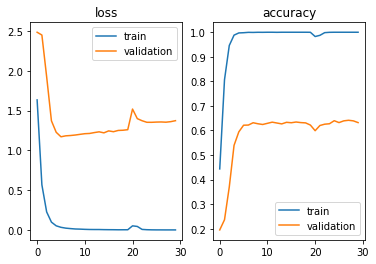

In [10]:
histories = train_model(model_3,'model_3', lr=0.0001, epochs=30)
evaluate(histories)

Epoch 1/30
136/136 [==============================] - 3s 19ms/step - loss: 1.5114 - categorical_accuracy: 0.4535 - val_loss: 1.9863 - val_categorical_accuracy: 0.2389
Epoch 2/30
136/136 [==============================] - 2s 17ms/step - loss: 0.6048 - categorical_accuracy: 0.7969 - val_loss: 2.2842 - val_categorical_accuracy: 0.2153
Epoch 3/30
136/136 [==============================] - 2s 17ms/step - loss: 0.2553 - categorical_accuracy: 0.9372 - val_loss: 1.8795 - val_categorical_accuracy: 0.4100
Epoch 4/30
136/136 [==============================] - 2s 17ms/step - loss: 0.1036 - categorical_accuracy: 0.9860 - val_loss: 1.3280 - val_categorical_accuracy: 0.5723
Epoch 5/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0488 - categorical_accuracy: 0.9963 - val_loss: 1.2039 - val_categorical_accuracy: 0.6018
Epoch 6/30
136/136 [==============================] - 2s 17ms/step - loss: 0.0292 - categorical_accuracy: 0.9993 - val_loss: 1.2163 - val_categorical_accuracy: 0.619

Epoch 20/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 1.2846 - val_categorical_accuracy: 0.6283
Epoch 21/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 1.2935 - val_categorical_accuracy: 0.6401
Epoch 22/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 1.2929 - val_categorical_accuracy: 0.6431
Epoch 23/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0021 - categorical_accuracy: 1.0000 - val_loss: 1.4457 - val_categorical_accuracy: 0.6195
Epoch 24/30
136/136 [==============================] - 2s 16ms/step - loss: 0.2798 - categorical_accuracy: 0.9077 - val_loss: 3.2652 - val_categorical_accuracy: 0.4395
Epoch 25/30
136/136 [==============================] - 2s 16ms/step - loss: 0.3473 - categorical_accuracy: 0.8796 - val_loss: 1.7461 - val_categorical_accuracy:

Epoch 9/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0108 - categorical_accuracy: 0.9993 - val_loss: 1.3846 - val_categorical_accuracy: 0.5651
Epoch 10/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0070 - categorical_accuracy: 1.0000 - val_loss: 1.3684 - val_categorical_accuracy: 0.5680
Epoch 11/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0056 - categorical_accuracy: 1.0000 - val_loss: 1.3977 - val_categorical_accuracy: 0.5828
Epoch 12/30
136/136 [==============================] - 2s 17ms/step - loss: 0.0081 - categorical_accuracy: 1.0000 - val_loss: 1.3913 - val_categorical_accuracy: 0.5799
Epoch 13/30
136/136 [==============================] - 2s 17ms/step - loss: 0.0049 - categorical_accuracy: 1.0000 - val_loss: 1.4051 - val_categorical_accuracy: 0.5828
Epoch 14/30
136/136 [==============================] - 2s 17ms/step - loss: 0.0035 - categorical_accuracy: 1.0000 - val_loss: 1.4158 - val_categorical_accuracy: 

Epoch 28/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0059 - categorical_accuracy: 0.9993 - val_loss: 1.6452 - val_categorical_accuracy: 0.5976
Epoch 29/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 1.6525 - val_categorical_accuracy: 0.5917
Epoch 30/30
136/136 [==============================] - 2s 16ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 1.6404 - val_categorical_accuracy: 0.6036


INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


best_epoch: 5 val_accuracy: 0.6113141775131226


(5, 0.6113141775131226)

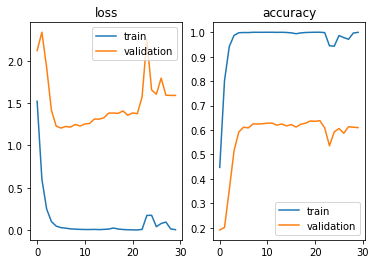

In [13]:
def model_4():
    model = tf.keras.Sequential([
    Rescaling(1./255),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
        
        
    Flatten(),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),

    Dense(6, activation='softmax')
    ])
    return model

histories = train_model(model_4,'model_4', lr=0.0001, epochs=30)
evaluate(histories)

By tunning the model parameters I was able to increase validation accuracy from 0.56 to 0.62. But that is still not enough. The bottleneck might be we have too few images in the dataset. What if we use transfer learning technique?

In [19]:

from keras import Input
from keras.applications import Xception

In [35]:
def model_5():
    base_model = Xception(
        weights='imagenet',
        input_shape=(224, 224, 3),
        include_top=False)
    # Freeze base model
    base_model.trainable = False
    
    inputs = Input(shape=(224, 224, 3))
    x = Rescaling(1./255)(inputs)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(64)(x)
    outputs = keras.layers.Dense(6, activation='softmax')(x)
    model = keras.Model(inputs, outputs) 
    return model

Epoch 1/30
136/136 [==============================] - 9s 55ms/step - loss: 0.3605 - categorical_accuracy: 0.9239 - val_loss: 0.0670 - val_categorical_accuracy: 0.9912
Epoch 2/30
136/136 [==============================] - 7s 50ms/step - loss: 0.0588 - categorical_accuracy: 0.9926 - val_loss: 0.0413 - val_categorical_accuracy: 0.9912
Epoch 3/30
136/136 [==============================] - 7s 50ms/step - loss: 0.0343 - categorical_accuracy: 0.9978 - val_loss: 0.0264 - val_categorical_accuracy: 0.9941
Epoch 4/30
136/136 [==============================] - 7s 50ms/step - loss: 0.0228 - categorical_accuracy: 0.9993 - val_loss: 0.0266 - val_categorical_accuracy: 0.9912
Epoch 5/30
136/136 [==============================] - 7s 51ms/step - loss: 0.0168 - categorical_accuracy: 0.9993 - val_loss: 0.0192 - val_categorical_accuracy: 0.9941
Epoch 6/30
136/136 [==============================] - 7s 51ms/step - loss: 0.0120 - categorical_accuracy: 1.0000 - val_loss: 0.0160 - val_categorical_accuracy: 0.994

Epoch 20/30
136/136 [==============================] - 7s 51ms/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 0.0264 - val_categorical_accuracy: 0.9941
Epoch 21/30
136/136 [==============================] - 7s 51ms/step - loss: 0.0013 - categorical_accuracy: 1.0000 - val_loss: 0.0265 - val_categorical_accuracy: 0.9941
Epoch 22/30
136/136 [==============================] - 7s 51ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 0.0264 - val_categorical_accuracy: 0.9941
Epoch 23/30
136/136 [==============================] - 7s 51ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 0.0260 - val_categorical_accuracy: 0.9941
Epoch 24/30
136/136 [==============================] - 7s 51ms/step - loss: 9.4362e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0258 - val_categorical_accuracy: 0.9941
Epoch 25/30
136/136 [==============================] - 7s 51ms/step - loss: 8.5111e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0262 - val_categorical_a

136/136 [==============================] - 7s 51ms/step - loss: 7.0177e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0213 - val_categorical_accuracy: 0.9970
Epoch 27/30
136/136 [==============================] - 7s 51ms/step - loss: 6.3847e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0209 - val_categorical_accuracy: 0.9970
Epoch 28/30
136/136 [==============================] - 7s 51ms/step - loss: 5.8905e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0202 - val_categorical_accuracy: 0.9970
Epoch 29/30
136/136 [==============================] - 7s 50ms/step - loss: 5.4199e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0204 - val_categorical_accuracy: 0.9970
Epoch 30/30
136/136 [==============================] - 7s 51ms/step - loss: 4.9293e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0206 - val_categorical_accuracy: 0.9970


INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


best_epoch: 29 val_accuracy: 0.9952767372131348


(29, 0.9952767372131348)

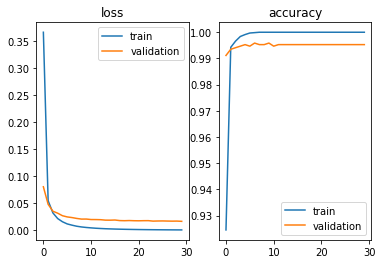

In [36]:
histories = train_model(model_5,'model_5', lr=0.0001, epochs=10)
evaluate(histories)

With imagenet as a pretrained model